<a href="https://colab.research.google.com/github/jrosko/Cyano_ImgAnalysis/blob/main/pre_process_doc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes and Testing of the image denoising/thresholding function (pre_process)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pims
import cv2

## Load a test stack
## We're using the pims package to load tif stacks

path = r'D:\\Data_WW\\pos_6\\pos6_crop_1\\'
frames = pims.open(path + r'\*.tif')


# Initial Exploration
We choose a test image, and plot its histogram. We then denoise the image, and plot the denoised histogram as well.

*   Using a Non-Local Means filter to denoise



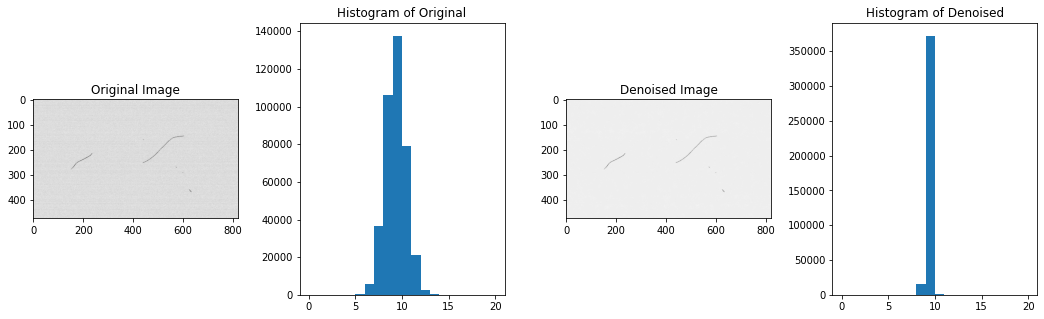

In [9]:
# Test Image
image = frames[11]

# Denoised Image
denoised = cv2.fastNlMeansDenoising(image,templateWindowSize=7, searchWindowSize=21, h=0.7)

#Plot
fig, ax = plt.subplots(1, 4, figsize=(18,5))

ax[0].imshow(image, cmap = 'Greys')
ax[0].set_title('Original Image')

ax[1].hist(image.flat, bins = 20, range=(0,20))
ax[1].set_title('Histogram of Original')

ax[2].imshow(denoised, cmap='Greys')
ax[2].set_title('Denoised Image')

ax[3].hist(denoised.flat, bins = 20, range=(0,20))
ax[3].set_title('Histogram of Denoised')

fig.subplots_adjust(wspace=0.3)
plt.show()

# Thresholding Possibilities

*   Binary Threshold of original image
*   Binary Threshold of denoised image
*   Otsu Threshold of original image
*   Otsu Threshold of denoised image



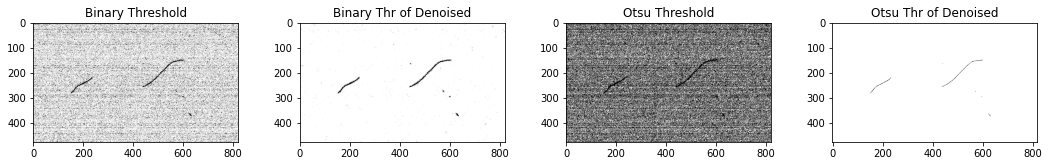

Otsu value for noisy image:  8.0
Otsu value for denoised image:  13.0


In [10]:
# 10 px looks reasonable for binary threshold by looking at above
ret_bin, thr_bin = cv2.threshold(image, 9, 200, cv2.THRESH_BINARY)
ret_bin_dn, thr_bin_dn = cv2.threshold(denoised, 9, 255, cv2.THRESH_BINARY)
ret_otsu, thr_otsu = cv2.threshold(image, 9, 255, cv2.THRESH_OTSU)
ret_otsu_dn, thr_otsu_dn = cv2.threshold(denoised, 9, 255, cv2.THRESH_OTSU)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(18,5))

ax[0].imshow(thr_bin, cmap = 'Greys')
ax[0].set_title('Binary Threshold')

ax[1].imshow(thr_bin_dn, cmap='Greys')
ax[1].set_title('Binary Thr of Denoised')

ax[2].imshow(thr_otsu, cmap='Greys')
ax[2].set_title('Otsu Threshold')

ax[3].imshow(thr_otsu_dn, cmap='Greys')
ax[3].set_title('Otsu Thr of Denoised')

fig.subplots_adjust(wspace=0.3)
plt.show()

print('Otsu value for noisy image: ', ret_otsu)
print('Otsu value for denoised image: ', ret_otsu_dn)


Opting for NL-Means Denoise + Binary Threshold.
Still need to remove some smaller blobs. This can be done by morphological opening.

For this image threshold = 9, if I do threshold = 10, I don't need the opening operation.
However I think smaller thr. + opening is maybe a bit more robust for this image.

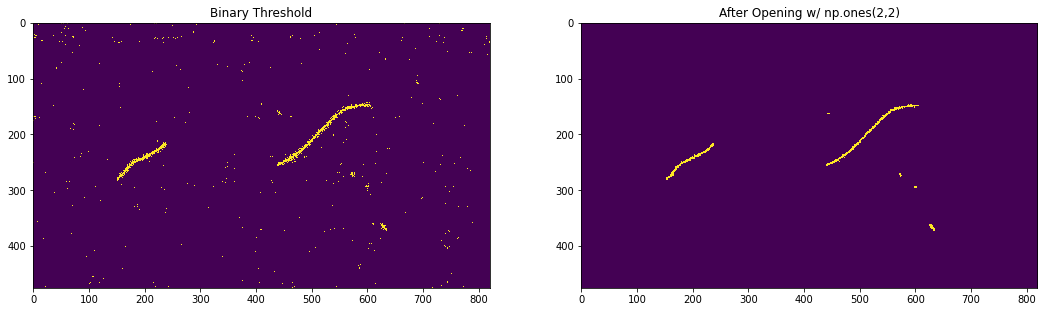

In [11]:
kernel = np.ones((2,2), np.uint8)
opening = cv2.morphologyEx(thr_bin_dn, cv2.MORPH_OPEN,kernel, iterations = 1)

fig, ax = plt.subplots(1, 2, figsize=(18,5))

ax[0].imshow(thr_bin_dn, interpolation = 'none')
ax[0].set_title('Binary Threshold')

ax[1].imshow(opening, interpolation='none')
ax[1].set_title('After Opening w/ np.ones(2,2)')

plt.show()

Putting it all together into a function

In [13]:
def pre_process(input_frame,  thr_val, denoise =  True, op_ker_d = 2):
    """ 
    Denoise and threshold a frame.
    Uses a non-local means filter to denoise (pass denoise = False to not). 
    Applies a binary threshold of thr_val.
    Performs morphological opening to remove any leftover noise patches.
    op_ker_d is the kernel dimension for opening.
    """
    if denoise == True:
        input_frame = cv2.fastNlMeansDenoising(input_frame,templateWindowSize=7, searchWindowSize=21, h=0.7)
    
    ret_bin, thr_bin = cv2.threshold(input_frame, thr_val, 255, cv2.THRESH_BINARY)

    kernel = np.ones((op_ker_d,op_ker_d), np.uint8)
    opening = cv2.morphologyEx(thr_bin, cv2.MORPH_OPEN,kernel, iterations = 1)

    return opening
    
    


Test the function

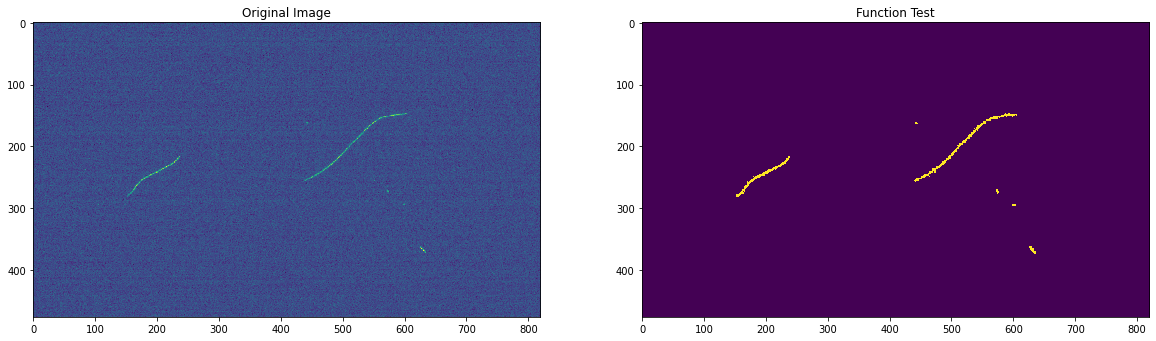

In [22]:
processed = pre_process(image, 9)

fig, ax = plt.subplots(1,2, figsize = (20,16))

ax[0].imshow(image, interpolation = 'none')
ax[0].set_title('Original Image')
ax[1].imshow(processed, interpolation = 'none')
ax[1].set_title('Function Test')

plt.show()